In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

In [0]:
def trainingTesting():
  classes={}
  trainingDt=[]
  testingDt={}
  # initialCoordinate=(0,0)
  count=0
  bigFolder='face_dataset'
  for miniFolder in os.listdir(bigFolder+'/'):
    newData = []
    for file in os.listdir(bigFolder+'/'+miniFolder+'/'):
      str1=bigFolder+'/'+miniFolder+'/'
      im=cv2.imread(str1+file)
      # print(im)
      im=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
      # print(im)
      initialCoordinate=im.shape
      im=im.flatten()
      # print(im)
      newData.append(im)
    size=len(newData)
    # print(newData)
    train_size=(70/100)*size
    for i in range(size):
      className=miniFolder
      if i<train_size:
        if className in classes:
          classes[className].append(count)
        else:
          classes[className]=[]
          classes[className].append(count)
        trainingDt.append(newData[i])
        count+=1
      else:
        if className in testingDt:
          testingDt[className].append(newData[i])
        else:
          testingDt[className]=[]
          testingDt[className].append(newData[i])
        # testingDt.append([newData[i],miniFolder])
  trainingDt=np.asarray(trainingDt)
  # testingDt=np.asarray(testingDt)
  return trainingDt,testingDt,classes,initialCoordinate

In [10]:
trainingDt,testingDt,classes,initialCoordinate=trainingTesting()
print(trainingDt.shape)
# print(testingDt.shape)

(280, 10304)


In [0]:
def mean(trainingDt):
  row=trainingDt.shape[0]
  col=trainingDt.shape[1]
  meanList=[0 for i in range(col)]
  for i in range(col):
    total=np.sum(trainingDt[:,i])
    total/=col
    meanList[i]=total
  meanList=np.asarray(meanList)
  deviatedList=np.subtract(trainingDt,meanList)
  return meanList,deviatedList

In [0]:
def cov(meanList,deviatedList):
  size=len(deviatedList)
  covarianceList=np.dot(deviatedList.T,deviatedList)*(1/size)
  return covarianceList

In [0]:
def reduceFeature(trainingDt,deviatedList,EigenVector):
  redFactor=100
  reducedEigenVectors=EigenVector[:,:redFactor]
  eigenFaces=np.dot(trainingDt,reducedEigenVectors)
  # newFeatures=np.dot(deviatedList,eigenFaces.T)
  # newFeatures=[]
  return redFactor,eigenFaces,reducedEigenVectors

In [14]:
meanList,deviatedList=mean(trainingDt)
print(meanList.shape)
deviatedList.shape

(10304,)


(280, 10304)

In [15]:
covarianceList=cov(meanList,deviatedList)
covarianceList.shape

(10304, 10304)

In [0]:
EigenVector,v,d = np.linalg.svd(covarianceList)

In [0]:
redFactor,eigenFaces,reducedEigenVectors=reduceFeature(trainingDt,deviatedList,EigenVector)

In [18]:
eigenFaces.shape

(280, 100)

In [0]:
def lda(redFactor,eigenFaces,classes):
  scattInsideClass=np.zeros((redFactor,redFactor))
  scattBetwClasses=np.zeros((redFactor,redFactor))

  MeanEigenFace, dev=mean(eigenFaces)
  MeanEigenFace=MeanEigenFace.reshape(redFactor,1)
  for className, num in classes.items():
    eigenImg=np.copy(eigenFaces[num])
    meanEigenImg, dev1 = mean(eigenImg)
    meanEigenImg=meanEigenImg.reshape(redFactor,1)
    for image in eigenImg:
      image=image.reshape(redFactor,1)
      a=np.subtract(image,meanEigenImg)
      scattInsideClass+=(np.dot(a,a.T))
    # print(meanEigenImg.shape,eigenImg.shape)
    
    # print(a.shape)
    # scattInsideClass+=(np.dot(a.T,a))
    scattBetwClasses+=(np.dot((np.subtract(MeanEigenFace,meanEigenImg)) , (np.subtract(MeanEigenFace,meanEigenImg)).T ))*(len(eigenImg))
  # b=np.dot(scattInsideClass)
  # print(scattInsideClass.shape,scattBetwClasses.shape)
  eigVectorLDA ,v,d = np.linalg.svd(np.dot(np.linalg.inv(scattInsideClass),scattBetwClasses))
  LDAredFactor=20
  eigVectorLDA=eigVectorLDA[:,:LDAredFactor]
  fisherFace=np.dot(eigenFaces,eigVectorLDA)
  return fisherFace,eigVectorLDA

In [0]:
fisherFace,eigVectorLDA=lda(redFactor,eigenFaces,classes)

In [0]:
def testing(testingDt,meanList,eigenFaces,classes,reducedEigenVectors):
  lengthTestData=0;
  count=0
  for actualClassName,value in testingDt.items():
    for face in value:
      predictedClassName=''
      nearestClassDist=1e19
      predictedClass=0
      # deviation=np.subtract(face,meanList)
      featureMatrix=np.dot(face,reducedEigenVectors)
      fisherImg=np.dot(featureMatrix,eigVectorLDA)
      numClasses=trainingDt.shape[0]
      for i in range(numClasses):
        dist=np.linalg.norm(np.subtract(fisherImg,fisherFace[i]))
        if(dist<nearestClassDist):
          nearestClassDist=dist
          predictedClass=i
      for key,val in classes.items():
        if predictedClass in val:
          predictedClassName=key
          break
      if predictedClassName==actualClassName:
        count+=1
      fig,ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].set_title('Given Image')
      ax[0].imshow(face.reshape(112,92), cmap='gray')
      ax[1].set_title('Predicted Image')
      ax[1].imshow(trainingDt[predictedClass].reshape(112,92), cmap='gray')
      lengthTestData+=1
  accuracy=(count/lengthTestData)*100
  return accuracy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


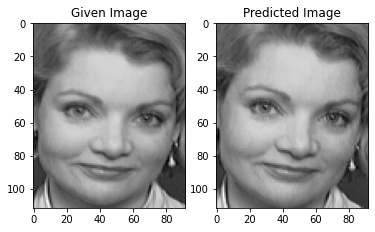

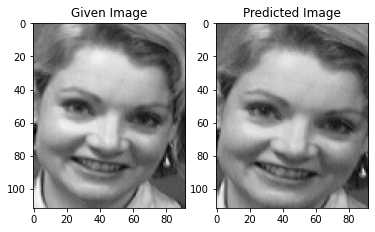

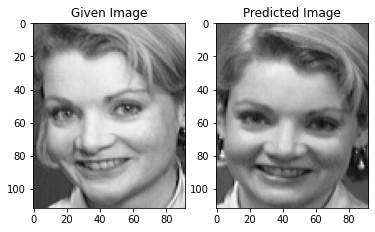

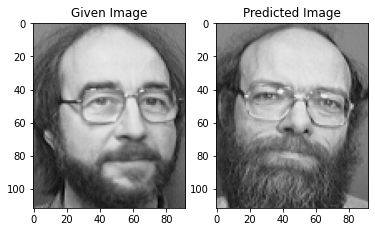

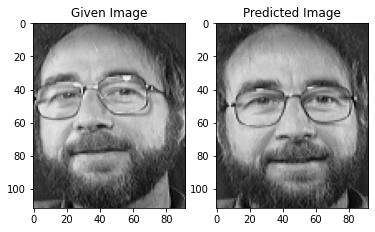

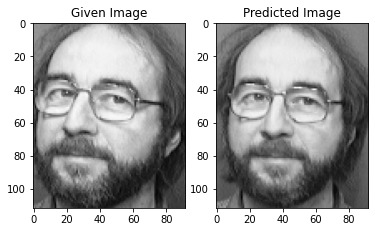

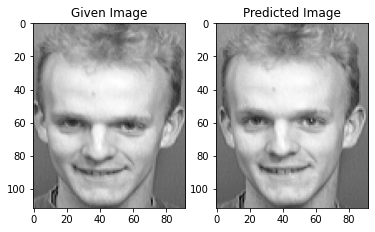

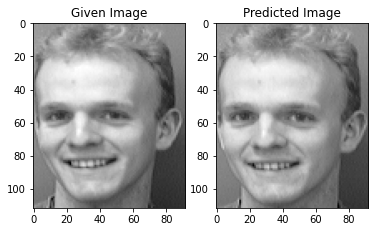

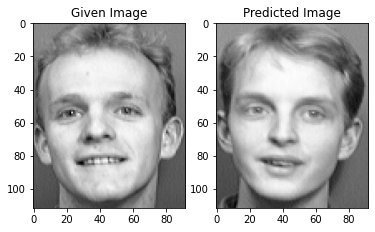

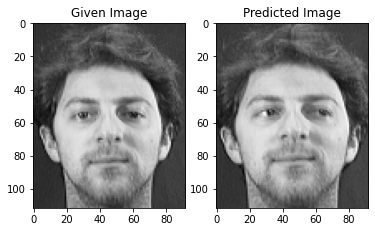

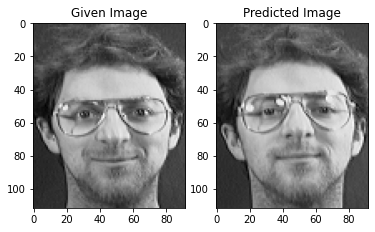

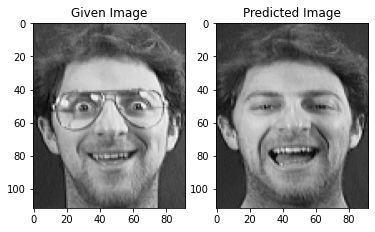

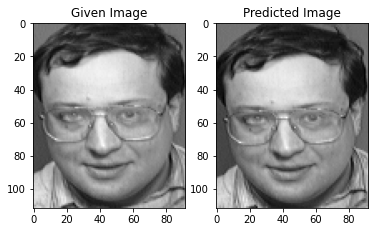

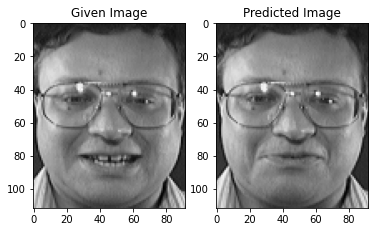

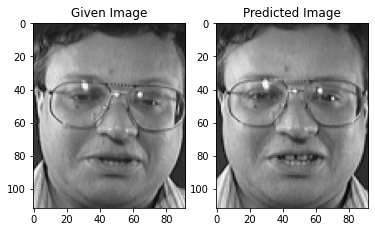

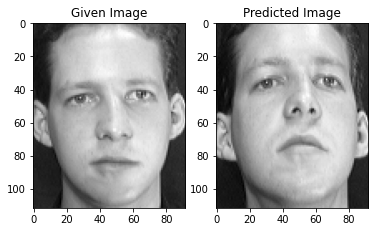

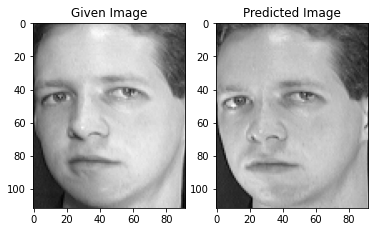

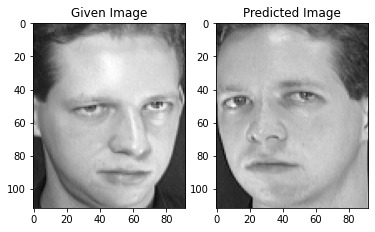

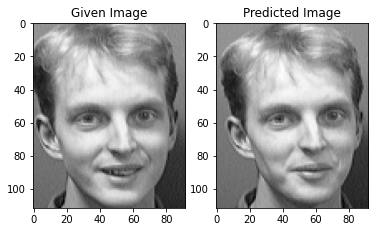

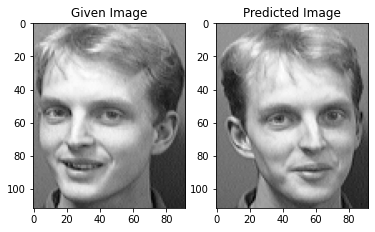

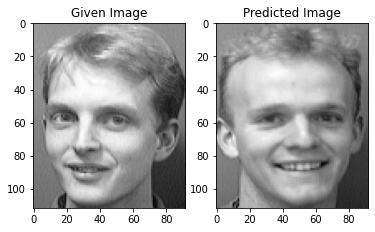

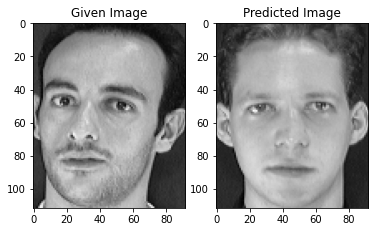

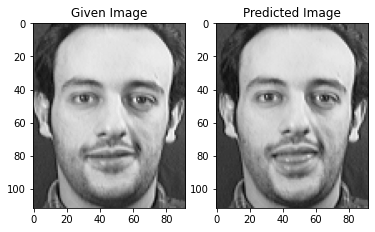

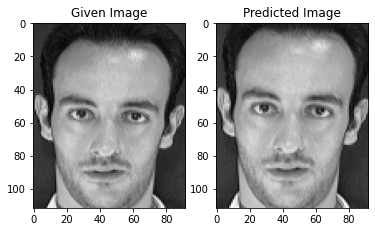

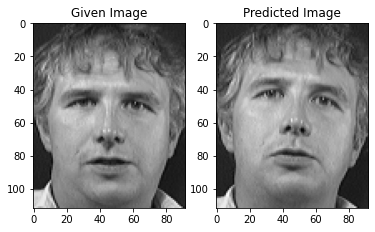

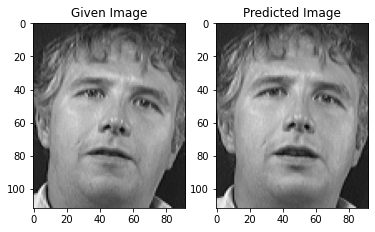

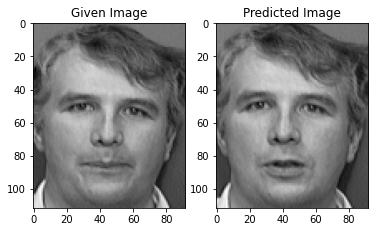

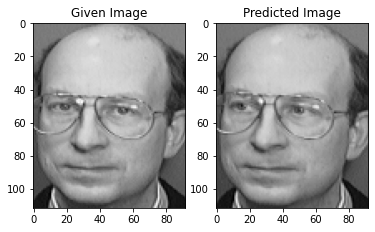

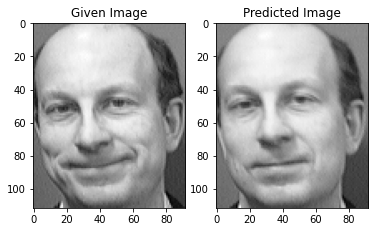

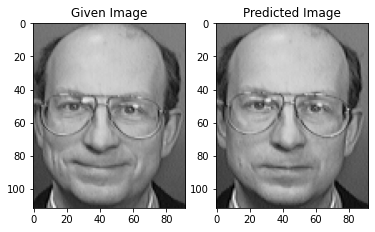

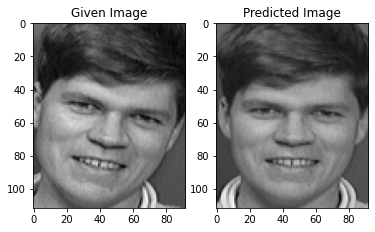

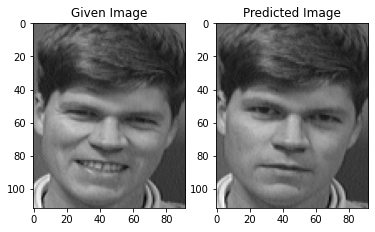

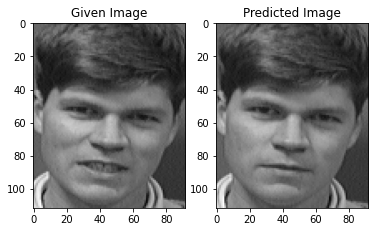

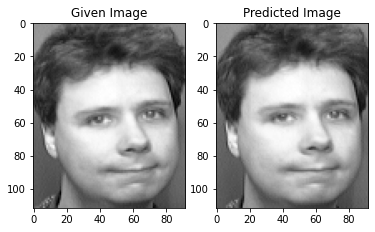

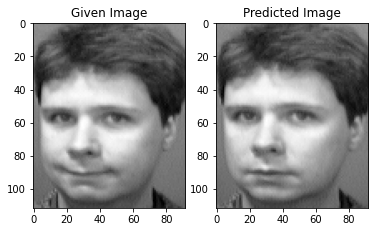

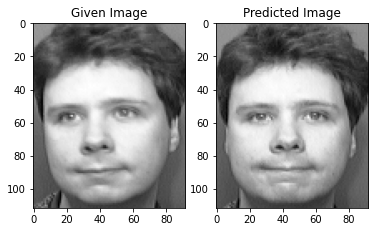

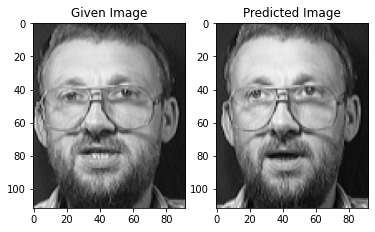

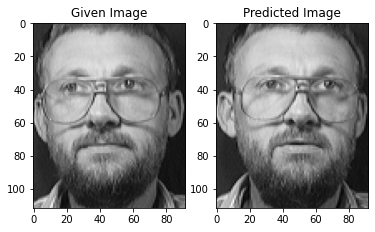

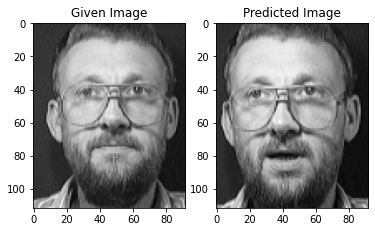

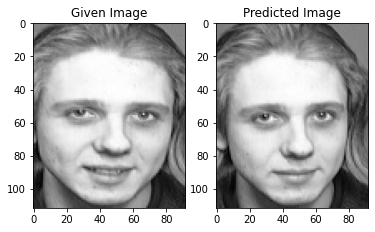

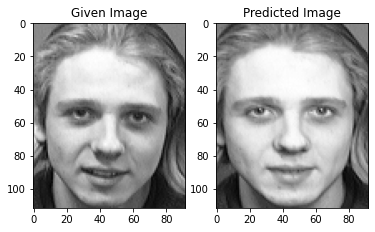

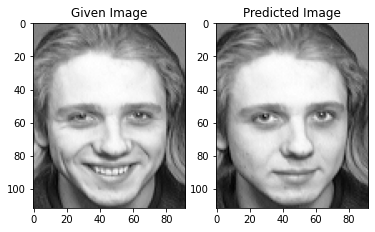

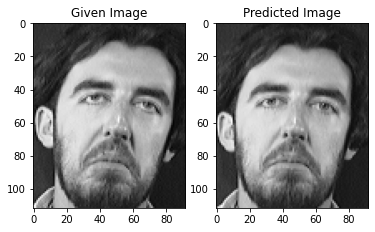

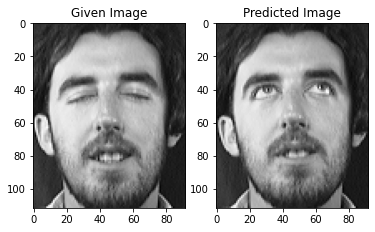

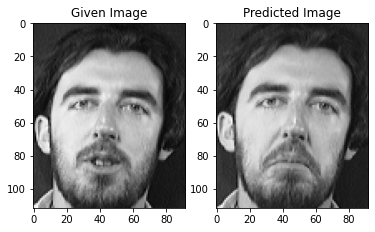

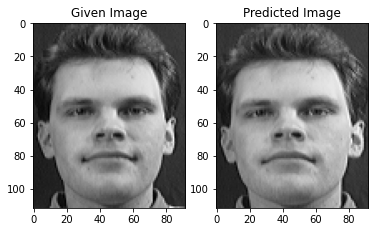

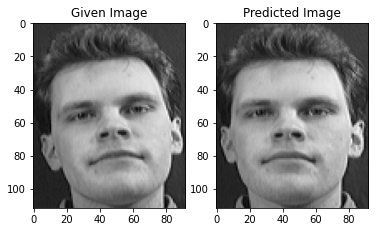

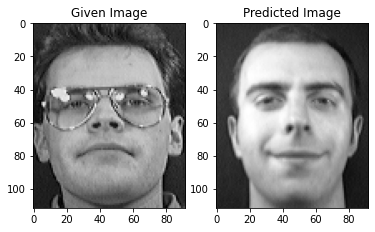

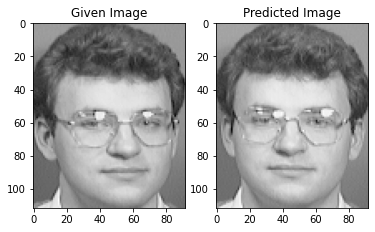

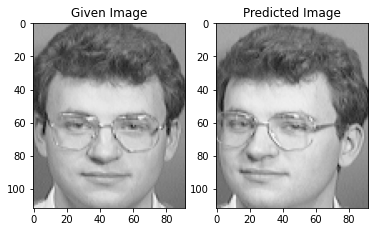

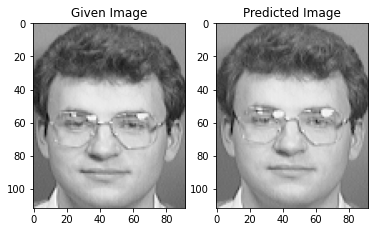

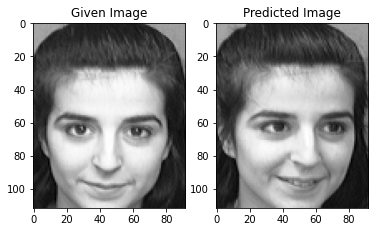

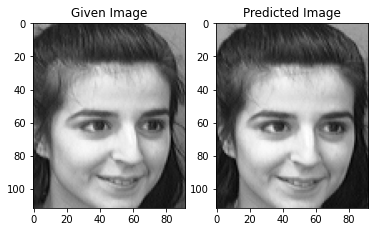

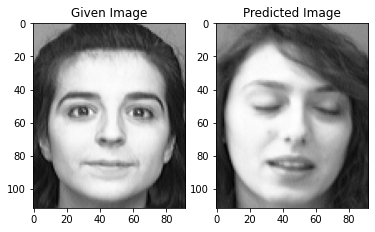

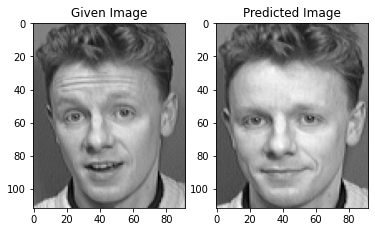

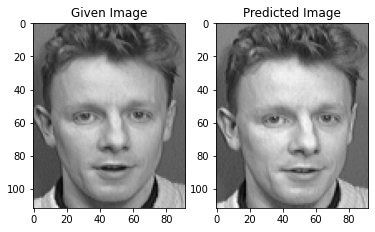

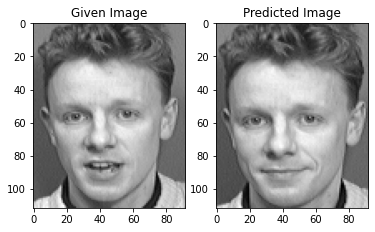

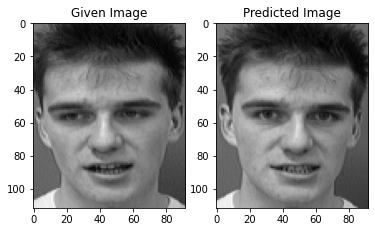

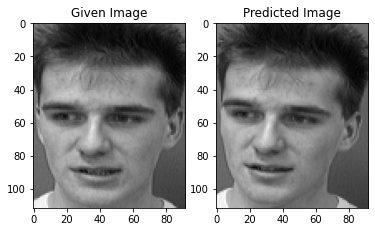

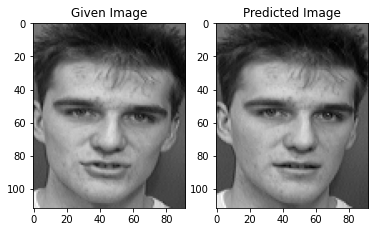

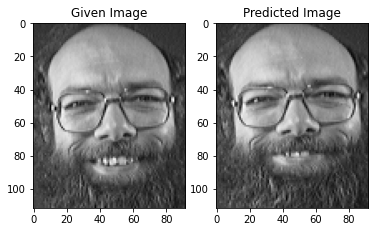

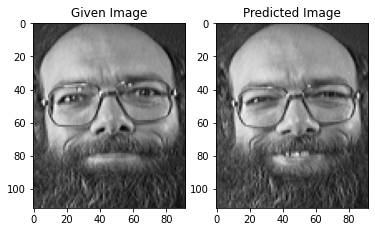

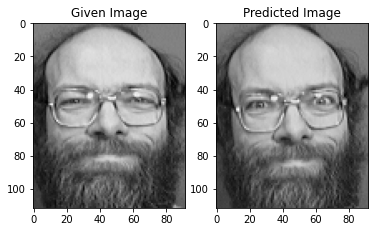

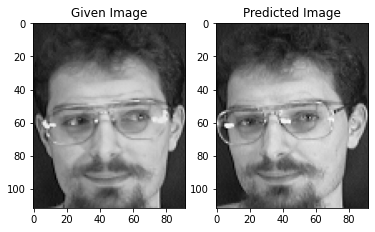

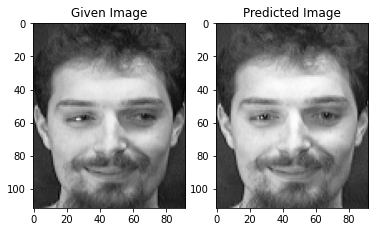

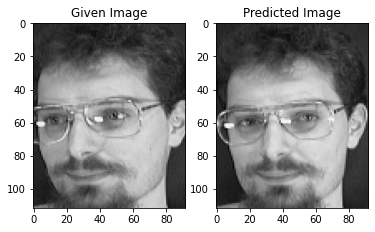

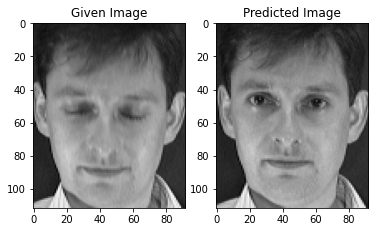

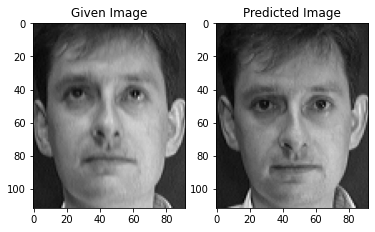

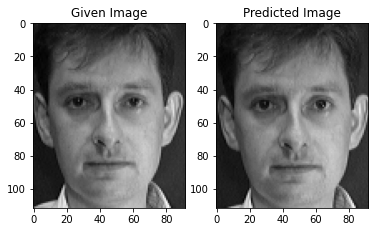

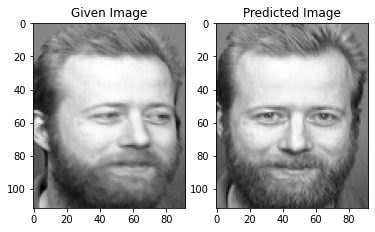

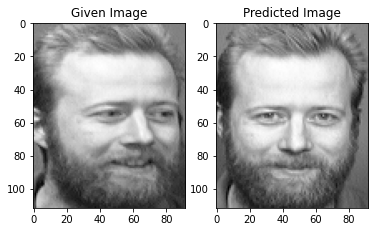

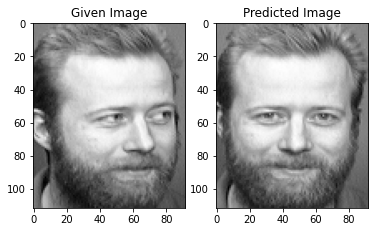

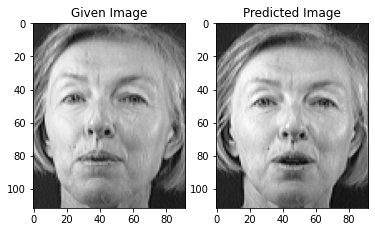

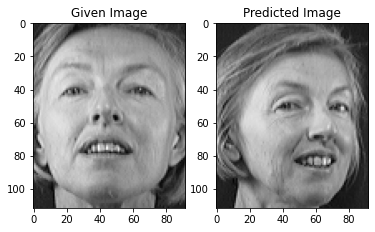

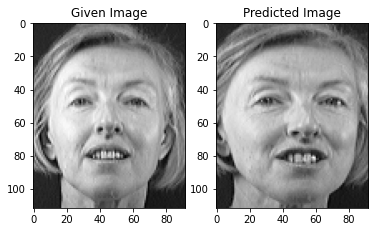

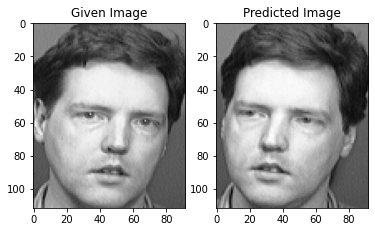

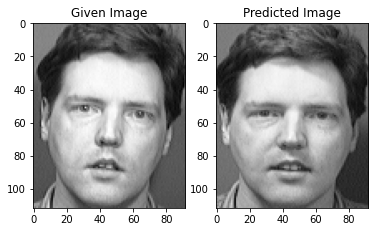

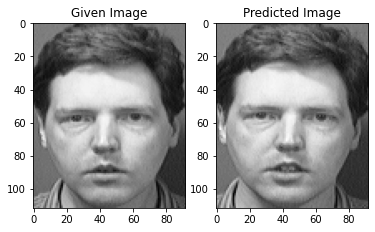

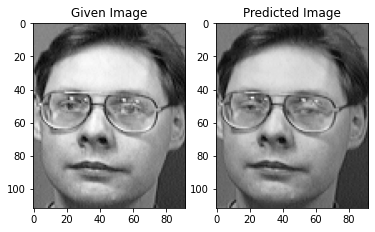

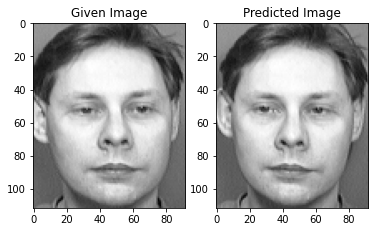

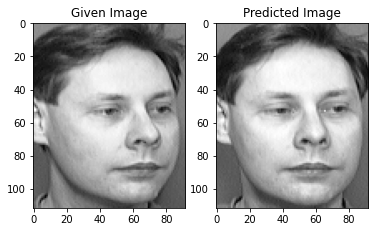

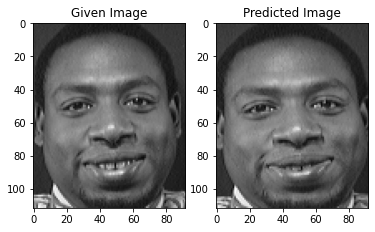

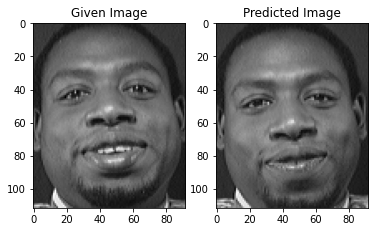

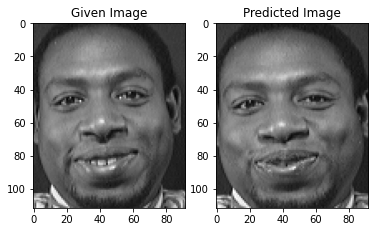

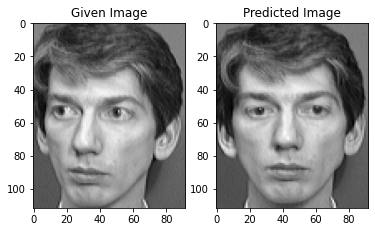

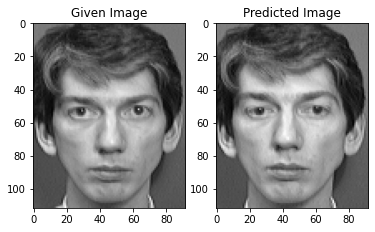

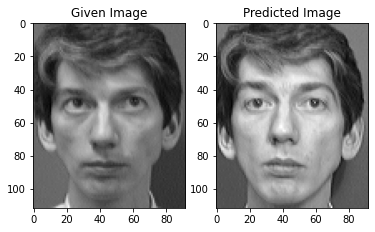

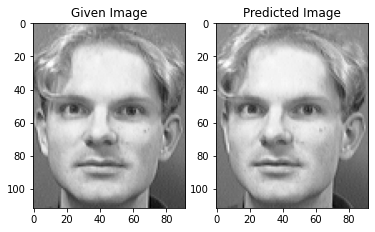

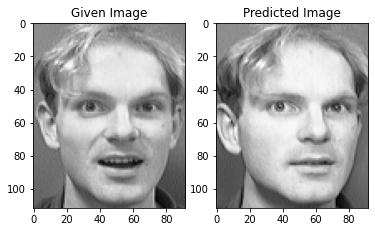

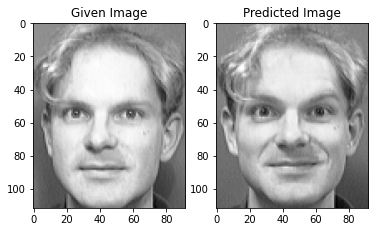

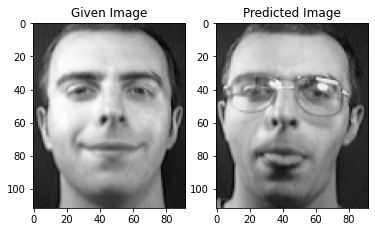

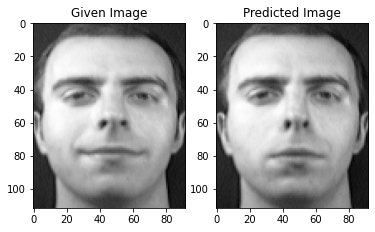

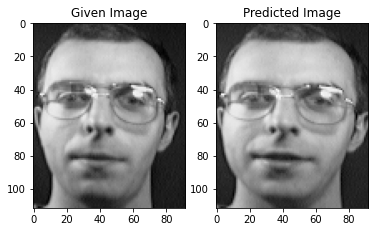

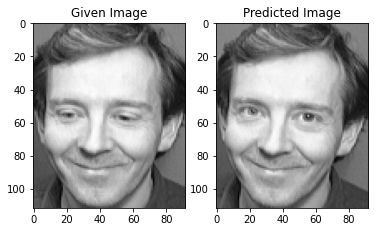

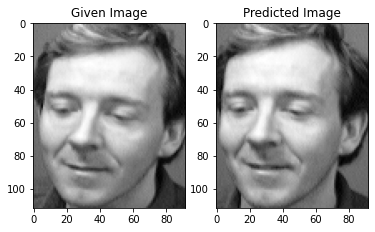

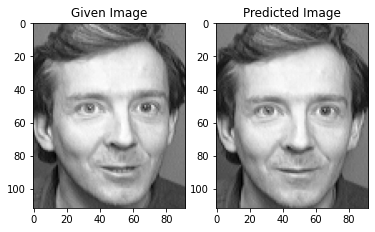

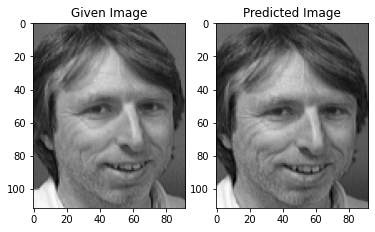

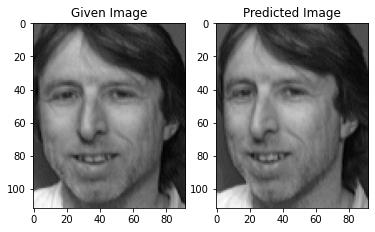

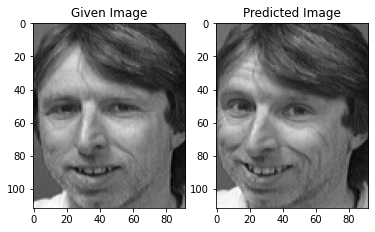

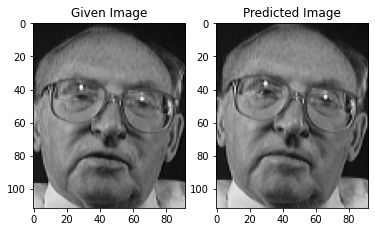

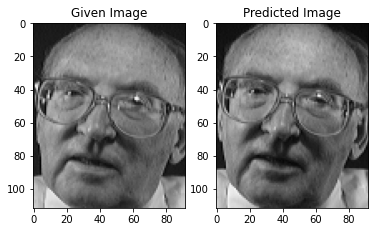

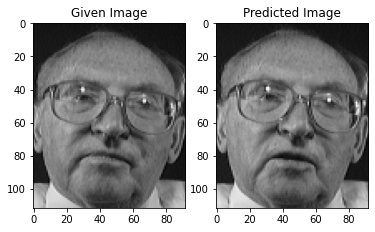

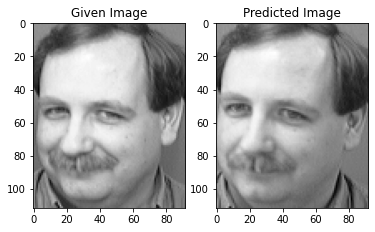

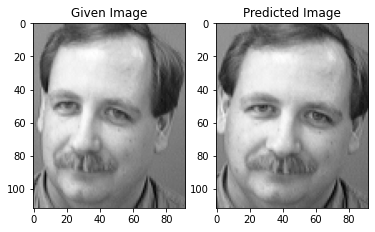

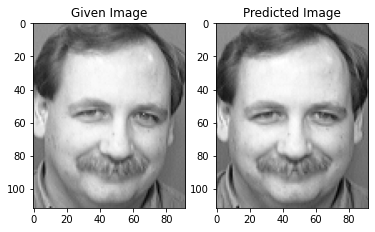

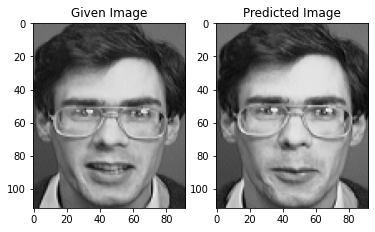

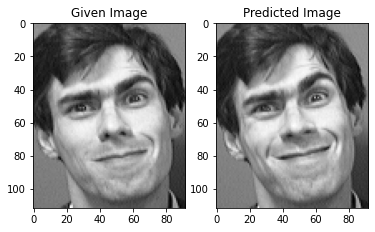

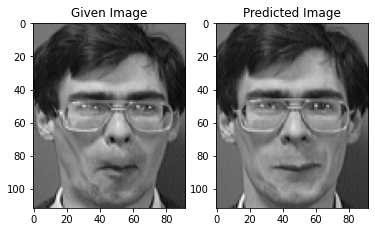

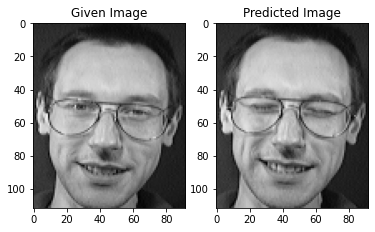

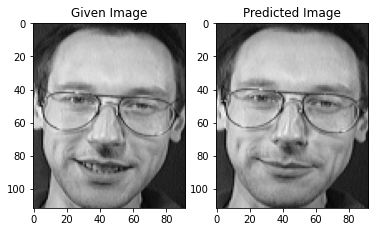

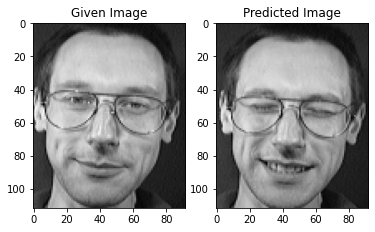

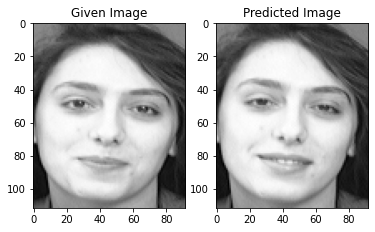

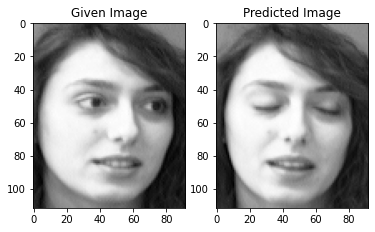

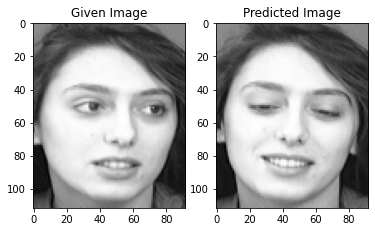

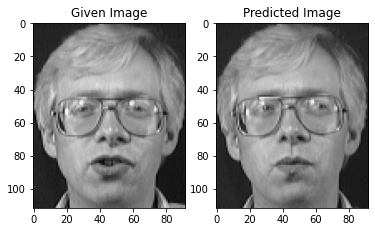

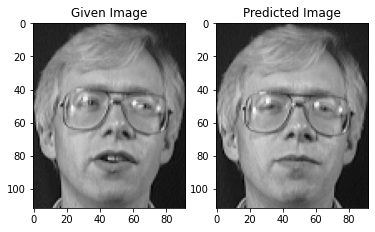

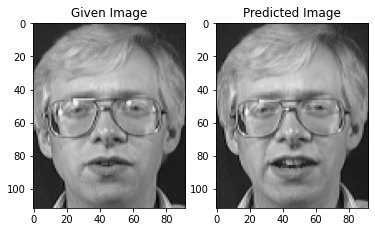

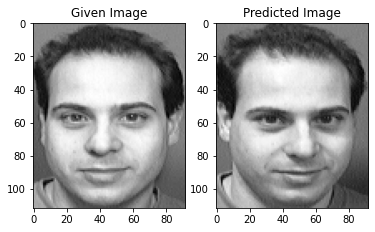

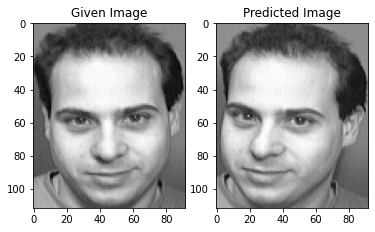

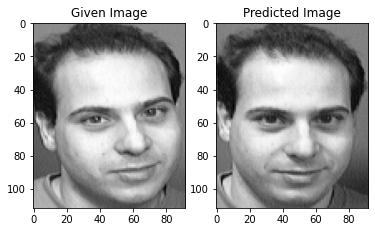

In [22]:
accuracy=testing(testingDt,meanList,eigenFaces,classes,reducedEigenVectors)

In [23]:
print(accuracy)

95.0
